#Multi-Head CNN Fusion Model with PSG-Audio
Uses flow and thoracic + abdominal respiratory band channels with Group 5-fold (hold-one-out) validation for the first 50 subjects of [PSG-Audio](https://www.scidb.cn/en/detail?dataSetId=778740145531650048).

If you use the PSG-Audio data in your work please cite the [paper](https://www.nature.com/articles/s41597-021-00977-w).

This is a slightly cleaned up version of our development code supporting the Fusion of Learned Representations for Multimodal Sensor Data Classification paper which is out for review.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.




# Imports

In [38]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

# Get PSG Audio first 50 subs IR3 X,y,sub arrays using gdrive link share
It is too big to do in one file.

X: https://drive.google.com/file/d/1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn/view?usp=share_link

y: https://drive.google.com/file/d/1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19/view?usp=share_link

sub: https://drive.google.com/file/d/1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk/view?usp=share_link

In [39]:
!gdown "1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn&confirm=t" # PSG first 50 sub X
!gdown "1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19&confirm=t" # PSG first 50 sub y
!gdown "1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk&confirm=t" # PSG first 50 sub sub blub blub

Downloading...
From: https://drive.google.com/uc?id=1-91S_9FgWlbrkfFzUoddDKJ2stLcf9Wn&confirm=t
To: /content/X.npy
100% 3.27G/3.27G [00:15<00:00, 210MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Ixhg8R7yIe7WJ3-1D1e2WL9VOaNea19&confirm=t
To: /content/y.npy
100% 136k/136k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-E29y3fH0Yo0IqxxDmQoYmAkki2t9PDk&confirm=t
To: /content/sub.npy
100% 272k/272k [00:00<00:00, 126MB/s]


In [40]:
# read in the arrays
X = np.load('X.npy')
y = np.load('y.npy')
sub = np.load('sub.npy')
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape              data type
-------  -----------------  -----------
X:       (136175, 500, 12)  float32
y:       (136175, 1)        int8
sub:     (136175, 1)        uint16


# Get flow and two respiratory bands Channels 9, 10, 11


In [41]:
x_fv0 = X[:,:,9]
x_fv0 = x_fv0[:,:,np.newaxis]
x_fv1 = X[:,:,10]
x_fv1 = x_fv1[:,:,np.newaxis]
x_fv2 = X[:,:,11]
x_fv2 = x_fv2[:,:,np.newaxis]
headers = ("Array","shape", "data type")
mydata = [("X:", X.shape, X.dtype),
          ("x_fv0:", x_fv0.shape, x_fv0.dtype),
          ("x_fv1:", x_fv1.shape, x_fv1.dtype),
          ("x_fv2:", x_fv2.shape, x_fv2.dtype),
        ("y:", y.shape, y.dtype),
        ("sub:", sub.shape, sub.dtype)]
print("\n",tabulate(mydata, headers=headers))


 Array    shape              data type
-------  -----------------  -----------
X:       (136175, 500, 12)  float32
x_fv0:   (136175, 500, 1)   float32
x_fv1:   (136175, 500, 1)   float32
x_fv2:   (136175, 500, 1)   float32
y:       (136175, 1)        int8
sub:     (136175, 1)        uint16


# Multi-Head Model

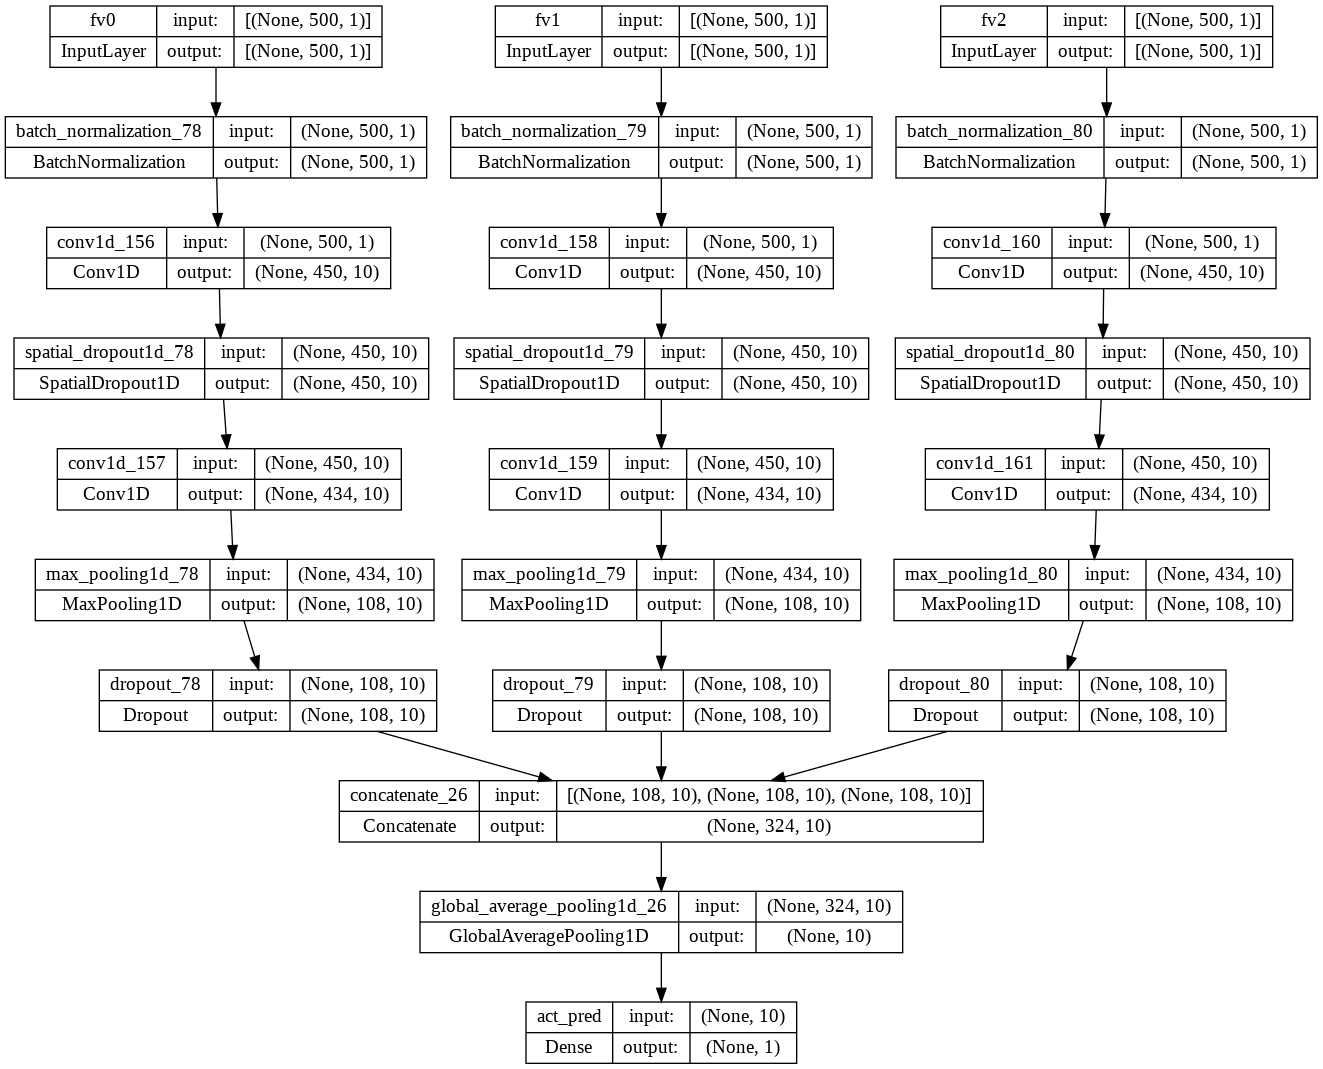

In [42]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/
def build_3input_CNN(x_train_fv0, x_train_fv1, x_train_fv2, y_train):
    n_outputs = y_train.shape[1]
    # input layers - 1st dim is timesteps, 2nd is features
    fv0_input = keras.Input(shape = (x_train_fv0.shape[1], x_train_fv0.shape[2]), name = "fv0")
    fv1_input = keras.Input(shape = (x_train_fv1.shape[1], x_train_fv1.shape[2]), name = "fv1")
    fv2_input = keras.Input(shape = (x_train_fv2.shape[1], x_train_fv2.shape[2]), name = "fv2")

    #if (feature_vector == "Raw TS Data"):
    fv0 = layers.BatchNormalization()(fv0_input)
    fv0 = layers.Conv1D(filters=10, kernel_size=51, activation='relu')(fv0)
    fv0 = layers.SpatialDropout1D(0.2)(fv0)
    fv0 = layers.Conv1D(filters=10, kernel_size=17, activation='relu')(fv0)
    fv0 = layers.MaxPooling1D(pool_size=4)(fv0)
    fv0 = layers.Dropout(0.2)(fv0)

    fv1 = layers.BatchNormalization()(fv1_input)
    fv1 = layers.Conv1D(filters=10, kernel_size=51, activation='relu')(fv1)
    fv1 = layers.SpatialDropout1D(0.2)(fv1)
    fv1 = layers.Conv1D(filters=10, kernel_size=17, activation='relu')(fv1)
    fv1 = layers.MaxPooling1D(pool_size=4)(fv1)
    fv1 = layers.Dropout(0.2)(fv1)

    fv2 = layers.BatchNormalization()(fv2_input)
    fv2 = layers.Conv1D(filters=10, kernel_size=51, activation='relu')(fv2)
    fv2 = layers.SpatialDropout1D(0.2)(fv2)
    fv2 = layers.Conv1D(filters=10, kernel_size=17, activation='relu')(fv2)
    fv2 = layers.MaxPooling1D(pool_size=4)(fv2)
    fv2 = layers.Dropout(0.2)(fv2)

    merged = layers.Concatenate(axis=1)([fv0, fv1, fv2])
    merged = layers.GlobalAveragePooling1D()(merged)
    
    #model.add(Attention(return_sequences= not cfg.KSUM))
    # line above is Alex's original call in sequential model - fails since model is not yet declared
    #attn = Attention(return_sequences= False)(merged)
    #attn = AttnSelf(cfg.SEQLENGTH,return_sequences= False)(merged)
    #merged = layers.Flatten()(attn)
    #merged = layers.Dense(100, activation='relu')(merged)
    #merged = layers.Dense(50, activation='relu')(fv0)
    pred = layers.Dense(n_outputs, activation='softmax', name='act_pred')(merged)

    model = keras.Model(
        inputs=[fv0_input, fv1_input, fv2_input],
        outputs=[pred],
    )
    return model

model = build_3input_CNN(x_fv0, x_fv1, x_fv2, y)
# model.summary()
display(keras.utils.plot_model(model, "3input_CNN_model.png", show_shapes=True))


In [43]:
def train_3input_CNN(model, x_train_fv0, x_train_fv1, x_train_fv2, y_train,
                                  x_test_fv0, x_test_fv1, x_test_fv2, y_test,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 200): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    opt = keras.optimizers.Adam(learning_rate=0.001) # was 0.0001
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    history = model.fit(
        {"fv0": x_train_fv0, "fv1": x_train_fv1, "fv2": x_train_fv2},
        {"act_pred": y_train},
        #batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=({"fv0": x_test_fv0, "fv1": x_test_fv1,
                          "fv2": x_test_fv2}, y_test),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/200
3336/3336 [==============================] - 24s 7ms/step - loss: 0.3768 - accuracy: 0.8408 - val_loss: 0.3017 - val_accuracy: 0.8693
Epoch 2/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.3263 - accuracy: 0.8681 - val_loss: 0.2907 - val_accuracy: 0.8690
Epoch 3/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.3146 - accuracy: 0.8736 - val_loss: 0.2890 - val_accuracy: 0.8716
Epoch 4/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.3084 - accuracy: 0.8758 - val_loss: 0.3338 - val_accuracy: 0.8377
Epoch 5/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.3044 - accuracy: 0.8782 - val_loss: 0.2887 - val_accuracy: 0.8770
Epoch 6/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.3014 - accuracy: 0.8794 - val_loss: 0.2868 - val_accuracy: 0.8779
Epoch 7/200
3336/3336 [==============================] - 22s 7ms/step - loss: 0.2967 - accuracy: 0.8824 - val_loss: 

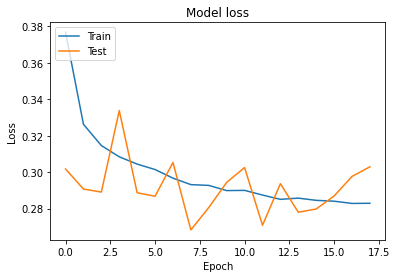

Fold 1:
Epoch 1/200
3495/3495 [==============================] - 24s 7ms/step - loss: 0.3568 - accuracy: 0.8477 - val_loss: 0.3878 - val_accuracy: 0.8238
Epoch 2/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.3258 - accuracy: 0.8665 - val_loss: 0.3721 - val_accuracy: 0.8324
Epoch 3/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.3044 - accuracy: 0.8758 - val_loss: 0.3803 - val_accuracy: 0.8337
Epoch 4/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.2953 - accuracy: 0.8806 - val_loss: 0.3779 - val_accuracy: 0.8302
Epoch 5/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.2875 - accuracy: 0.8846 - val_loss: 0.3629 - val_accuracy: 0.8412
Epoch 6/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.2843 - accuracy: 0.8863 - val_loss: 0.3644 - val_accuracy: 0.8447
Epoch 7/200
3495/3495 [==============================] - 23s 7ms/step - loss: 0.2799 - accuracy: 0.8878 - val_loss: 

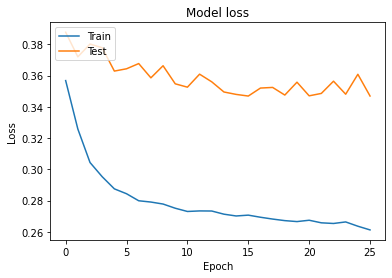

Fold 2:
Epoch 1/200
3440/3440 [==============================] - 24s 7ms/step - loss: 0.3738 - accuracy: 0.8405 - val_loss: 0.3016 - val_accuracy: 0.8798
Epoch 2/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3395 - accuracy: 0.8587 - val_loss: 0.2738 - val_accuracy: 0.8952
Epoch 3/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3265 - accuracy: 0.8675 - val_loss: 0.2720 - val_accuracy: 0.8948
Epoch 4/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3219 - accuracy: 0.8695 - val_loss: 0.2656 - val_accuracy: 0.9000
Epoch 5/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3174 - accuracy: 0.8709 - val_loss: 0.2627 - val_accuracy: 0.9000
Epoch 6/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3141 - accuracy: 0.8724 - val_loss: 0.2593 - val_accuracy: 0.9012
Epoch 7/200
3440/3440 [==============================] - 23s 7ms/step - loss: 0.3091 - accuracy: 0.8755 - val_loss: 

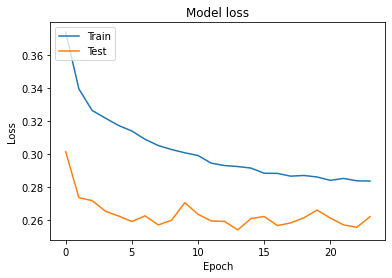

Fold 3:
Epoch 1/200
3381/3381 [==============================] - 24s 7ms/step - loss: 0.3577 - accuracy: 0.8455 - val_loss: 0.3411 - val_accuracy: 0.8698
Epoch 2/200
3381/3381 [==============================] - 22s 7ms/step - loss: 0.3309 - accuracy: 0.8616 - val_loss: 0.3220 - val_accuracy: 0.8826
Epoch 3/200
3381/3381 [==============================] - 23s 7ms/step - loss: 0.3202 - accuracy: 0.8679 - val_loss: 0.3126 - val_accuracy: 0.8779
Epoch 4/200
3381/3381 [==============================] - 23s 7ms/step - loss: 0.3122 - accuracy: 0.8732 - val_loss: 0.3261 - val_accuracy: 0.8601
Epoch 5/200
3381/3381 [==============================] - 22s 7ms/step - loss: 0.3077 - accuracy: 0.8756 - val_loss: 0.3045 - val_accuracy: 0.8857
Epoch 6/200
3381/3381 [==============================] - 22s 7ms/step - loss: 0.3036 - accuracy: 0.8784 - val_loss: 0.2918 - val_accuracy: 0.8897
Epoch 7/200
3381/3381 [==============================] - 22s 7ms/step - loss: 0.3007 - accuracy: 0.8797 - val_loss: 

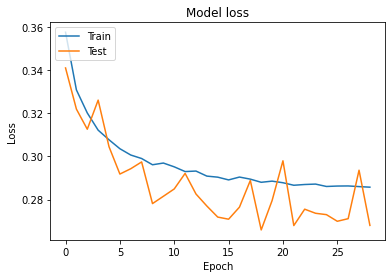

Fold 4:
Epoch 1/200
3371/3371 [==============================] - 22s 6ms/step - loss: 0.3537 - accuracy: 0.8495 - val_loss: 0.4081 - val_accuracy: 0.8409
Epoch 2/200
3371/3371 [==============================] - 21s 6ms/step - loss: 0.3266 - accuracy: 0.8651 - val_loss: 0.3342 - val_accuracy: 0.8691
Epoch 3/200
3371/3371 [==============================] - 21s 6ms/step - loss: 0.3067 - accuracy: 0.8747 - val_loss: 0.3213 - val_accuracy: 0.8771
Epoch 4/200
3371/3371 [==============================] - 20s 6ms/step - loss: 0.2996 - accuracy: 0.8799 - val_loss: 0.3005 - val_accuracy: 0.8868
Epoch 5/200
3371/3371 [==============================] - 20s 6ms/step - loss: 0.2957 - accuracy: 0.8821 - val_loss: 0.3026 - val_accuracy: 0.8833
Epoch 6/200
3371/3371 [==============================] - 20s 6ms/step - loss: 0.2923 - accuracy: 0.8836 - val_loss: 0.2994 - val_accuracy: 0.8831
Epoch 7/200
3371/3371 [==============================] - 20s 6ms/step - loss: 0.2891 - accuracy: 0.8839 - val_loss: 

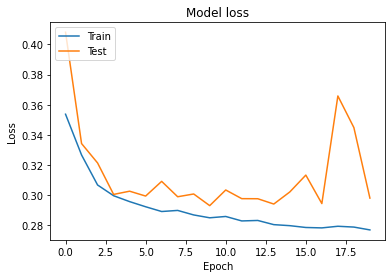

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.3029179871082306 - Accuracy: 86.69043779373169%
> Fold 1 - Accuracy: 86.69043779373169%
> Fold 2 - Loss: 0.3469523787498474 - Accuracy: 85.02588272094727%
> Fold 2 - Accuracy: 85.02588272094727%
> Fold 3 - Loss: 0.26229432225227356 - Accuracy: 89.6662712097168%
> Fold 3 - Accuracy: 89.6662712097168%
> Fold 4 - Loss: 0.26797351241111755 - Accuracy: 89.52690362930298%
> Fold 4 - Accuracy: 89.52690362930298%
> Fold 5 - Loss: 0.29801633954048157 - Accuracy: 88.42172026634216%
> Fold 5 - Accuracy: 88.42172026634216%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 87.86624312400818 (+- 1.775196590399176)
------------------------------------------------------------------------


In [44]:
# original source NNCLR_Multi_CNN_Funct_classifier_TWristAR_and_UE4W_4.ipynb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder

import sys

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_test_per_fold = []

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X, y, groups=sub)):
    print(f"Fold {i}:")

    x_train_fv0 = x_fv0[train_index]
    x_train_fv1 = x_fv1[train_index]
    x_train_fv2 = x_fv2[train_index]
    y_train = y[train_index]
 
    x_test_fv0 = x_fv0[test_index]
    x_test_fv1 = x_fv1[test_index]
    x_test_fv2 = x_fv2[test_index]
    y_test = y[test_index]

    enc = OneHotEncoder(categories='auto', sparse=False)
    y_train = enc.fit_transform(y_train)
    y_test = enc.fit_transform(y_test)

    # Generate generalization metrics
    model = build_3input_CNN(x_train_fv0, x_train_fv1, x_train_fv2, y_train)
    history, model = train_3input_CNN(model, x_train_fv0, x_train_fv1, x_train_fv2, y_train,
                                  x_test_fv0, x_test_fv1, x_test_fv2, y_test)
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1] 

    acc_per_fold.append(val_acc * 100)
    loss_per_fold.append(val_loss)

    # Generate predictions
    y_pred = model.predict({"fv0": x_test_fv0, "fv1": x_test_fv1, "fv2": x_test_fv2}, verbose = 1)

    y_pred = np.argmax(y_pred, axis=1)
    y_pred_per_fold.append(y_pred)
    y_test_per_fold.append(np.argmax(y_test, axis=1))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Confusion matrix, without normalization
[[93747  8134]
 [ 8335 25959]]


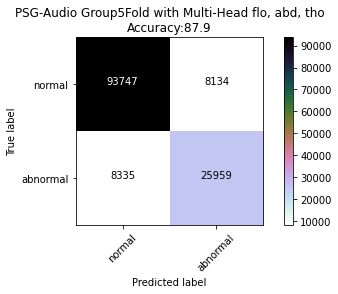

In [46]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

y_pred = np.concatenate(y_pred_per_fold)
y_test = np.concatenate(y_test_per_fold)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group5Fold with Multi-Head flo, abd, tho\n'
title += 'Accuracy:{0:.1f}'.format(np.mean(acc_per_fold))
plot_confusion_matrix(cm, classes=['normal','abnormal'], title=title, cmap='cubehelix_r')